Import third-party libraries needed and the custom functions in each step.

In [14]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from steps.explore import format_calendar_data
from steps.clean import clean_listings_data
from steps.random_forest import optimize_param
from steps.hypo_test import fisher_test, mannwhitneyu_test

%matplotlib inline

Load calendar.csv and plot it.

(array([1.073e+03, 8.450e+02, 5.290e+02, 2.690e+02, 1.110e+02, 4.400e+01,
        1.700e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([ 25. , 122.4, 219.8, 317.2, 414.6, 512. , 609.4, 706.8, 804.2,
        901.6, 999. ]),
 <BarContainer object of 10 artists>)

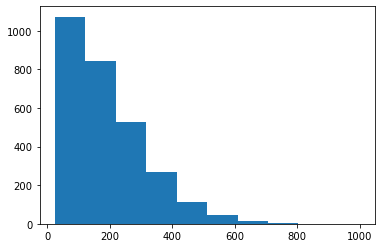

In [15]:
# 1. Explore the relationship between availability and price
calendar = pd.read_csv('./dataset/Boston/calendar.csv')
calendar.head()
# format the price column to numeric value, use log to normalize price value and exclude outliners
price_available_rate = format_calendar_data(calendar)

plt.hist(price_available_rate['price_num'])

Seems the price data is right-skewed, let's draw a dot plot to see the relationship between price and availability

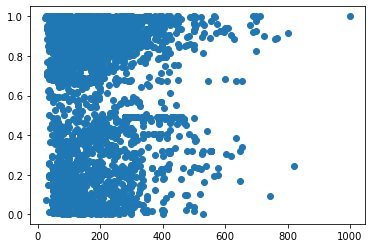

In [16]:
plt.scatter(price_available_rate['price_num'], price_available_rate['available_num'])
plt.savefig("images/explore.jpg")

Seems the relationship between price and availability is not linear, we cannot say the more expensive a property is, the fewer people book it. Since the variance of price is large, we use the log x-axis instead.

               price_num_log  available_num
price_num_log       1.000000      -0.030366
available_num      -0.030366       1.000000


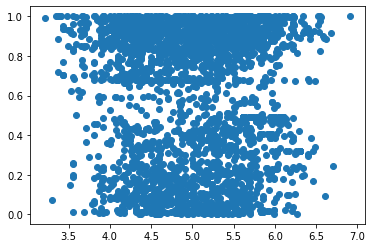

In [17]:
plt.scatter(price_available_rate['price_num_log'], price_available_rate['available_num'])
plt.savefig("images/explore-log.jpg")
print(price_available_rate[['price_num_log', 'available_num']].corr())

Clearly price and availability are not strongly linear related. By the way, the dots are clearly split into two groups along the y-axis, few dots spot around 0.5 availability.

Now, load the listing.csv dataset.

In [18]:
listings = pd.read_csv('./dataset/Boston/listings.csv')
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

Since there are 95 columns in the dataset, data cleaning is needed. After cleaning is done, save the dataframe into csv file for further studies.

In [19]:
listings = clean_listings_data(listings)
# save data to 
listings.to_csv("./dataset/boston_data_formatted.csv", encoding="utf_8_sig")

Split the dataset(3585 rows) into training and testing subsets. Try to predict the availability using price and other factors using LinearRegression model.

In [20]:
listings_X = listings.drop(['id', 'availability'], axis=1)
listings_y = listings['availability']
X_train, X_test, y_train, y_test = train_test_split(
    listings_X, listings_y, test_size=.2)

linear_model_sm = sm.OLS(y_train,sm.tools.add_constant(X_train).astype(float))
results_sm = linear_model_sm.fit()
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           availability   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     9.902
Date:                Thu, 08 Jul 2021   Prob (F-statistic):          1.07e-158
Time:                        10:17:25   Log-Likelihood:                -771.88
No. Observations:                2868   AIC:                             1828.
Df Residuals:                    2726   BIC:                             2674.
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Since R-squared score for the linear model is 0.339 which is not good enough, there might be strong multicollinearity problems. So let's try random forest model instead. Get the suitable tree number first.

20  trees
0.9013773926660239

30  trees
0.9070564246541568

50  trees
0.9120887627675864

100  trees
0.9163124704945383

200  trees
0.9183362259349865

500  trees
0.9196498959872556

1000  trees
0.9201371950051944



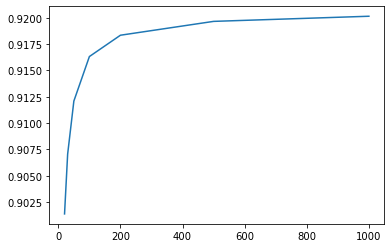

In [21]:
optimize_param(X_train, y_train)

The score on training data is pretty satisfactoring, over 0.91 when only 500 trees. Try to fit the model and have a plot.

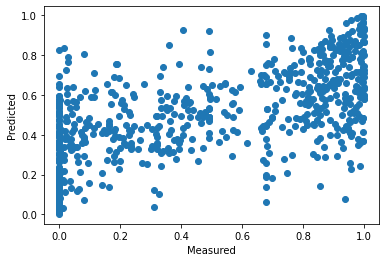

In [22]:
rf_regressor = RandomForestRegressor(n_estimators=500,oob_score=True,n_jobs=-1,
                                  random_state=42,max_features='auto')
rf_regressor.fit(X_train,y_train)
pred_y = rf_regressor.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y_test, pred_y)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.savefig("images/model.jpg")
plt.show()

In [23]:
rf_regressor.score(X_test,y_test)

0.4189067946027871

The score is still low on test dataset but higher than linear regression model.

Since the price of dataset is grouped into two, a hypothesis test can be done between those vacancy properties and popular ones on each columns to see which columns are significantly different.

Firstly, split the dataset into two and look for the features that differs most between the two groups

In [24]:
listings_low = listings[listings['availability'] < 0.5]
listings_high = listings[listings['availability'] >= 0.5]

For dummy columns, use fisher exact test and for numeric columns, use Mann-Whitney U test.

In [25]:
dummy_cols = listings.select_dtypes(include=['uint8', 'bool']).columns
numeric_cols = listings.drop(['id', 'availability'], axis=1).select_dtypes(include=['int', 'float']).columns
dummy_pval_high = fisher_test(listings_high, listings_low, columns=dummy_cols, alternative='greater')
dummy_pval_low = fisher_test(listings_high, listings_low, columns=dummy_cols, alternative='less')
numeric_pval_high = mannwhitneyu_test(listings_high, listings_low, columns=numeric_cols, alternative='greater')
numeric_pval_low = mannwhitneyu_test(listings_high, listings_low, columns=numeric_cols, alternative='less')

print(dummy_pval_high.sort_values())
print('')
print(dummy_pval_low.sort_values())
print('')
print(numeric_pval_high.sort_values())
print('')
print(numeric_pval_low.sort_values())


cancellation_policy_super_strict_30    6.772741e-23
host_about                             3.099518e-18
host_response_time_within an hour      9.874845e-15
property_type_House                    1.636632e-13
neighbourhood_cleansed_Dorchester      1.476822e-12
access                                 3.705482e-11
cancellation_policy_strict             1.113465e-10
notes                                  8.246343e-10
require_guest_phone_verification       1.410842e-07
amenities_Free_Parking_on_Premises     1.962251e-07
host_response_rate_MEDIUM              2.916042e-07
house_rules_LONG                       3.471529e-07
property_type_Bed & Breakfast          2.102175e-05
require_guest_profile_picture          2.149809e-04
host_is_superhost                      3.921017e-04
neighborhood_overview                  8.021362e-04
neighbourhood_cleansed_Roslindale      9.307441e-04
neighbourhood_cleansed_Mattapan        1.937062e-03
property_type_Boat                     2.206857e-03
host_accepta

It shows that strict **cancellation policy**, **requirement for guest’s phone verification**, **long house rules** are significant higher in vacancy properties. And those properties that are relatively **old**(high host_since), **hosted by superhost**(high host_listing_count) and **of high extra fees**(high extra_people, high cleaning_fee, high security_deposite) are less popular.

On the opposite, **flexible cancellation policy**, **neighborhood to Fenway/Allston** may be essential for popular properties and they have also significantly **higher scores in value, rating and accuracy reviewing**. Besides, **average pricing for the area** is also higher for popular properties(just like Fenway/Allston/Mission Hill/Chinatown), which could indicate that the even with higher price for renting a property in urban areas, availability there is still higher than rural areas.
